***
## [December 2018] - Measuring optimal M1 pitch for different gaps and energies
### Abstract:

We have been running a feedback loop on the exit slit horizontal baffles to adjust the M1 pitch - otherwise the horizontal beam position drifts away.

We thought for a while that this was purely an effect the heat load on M1. I think that is still a part of it, but we more recently began to suspect that it might be monochromator related.

In these two measurement sets we have:
1. Stepped through EPU gaps (tuning to the fundamental peak at each gap), then sweep M1 pitch while recording the intensity at the M4 photodiode. The maximum of this trace indicates a centered beam and hence correct M1 pitch

2. Fix the EPU gap and step through different photon energies. This time measure on the M4 gold mesh, since we wanted to be sure we weren't falling off the diode at low energies when the spatial beam profile is large.

In some cases the M1 pitch was performed twice in a row, just to verify that it was not changing with time (it wasn't)

These measurements show that the majority of the M1 pitch dependence is based on the monochromator energy setting, NOT the M1 heat load.


In [7]:
from BLOCH_beamline import *
data_folder = Path('Data/')
%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

***
### Local functions

In [8]:
from lmfit import minimize, Parameters

###########################
def residual(params, x, y):
###########################
	return (y-Gauss(params,x))

########################
def Gauss(params,x):
########################    
    amplitude = params['amplitude'].value
    center = params['center'].value
    width = params['width'].value
    offset = params['offset'].value

    model = offset + (amplitude*np.exp(-(x-center)**2/(2.*width**2))) 

    return model

In [9]:
def fitGaussToDiodeGapSet(filename,firstScan,lastScan,showPlots=False):
    output_m1_pitch=[]
    output_gap=[]
    output_hv=[]
    
    for scanNumber in range(firstScan,lastScan+1,1):
        if showPlots: fig = plt.figure(figsize=(8,8))
        scan = HDF5loadscan(data_folder/filename,scanNumber)    
        
        hv = scan['mono_energyposition'][0]
        gap = scan['EPU_R1_110_GAPposition'][0]

        if showPlots: print('------------ EPU gap = {0:.0f}, hv = {1:.1f}------------'.format(gap,hv))
        
        scan['diodeCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em02_ch03']]

        params = Parameters()
        maxCurrent = max(scan['diodeCurrent'])
        minCurrent= min(scan['diodeCurrent'])
        maxCurrentIndex = scan['diodeCurrent'].index(maxCurrent)
        correctPitch =scan['m1_pitch'][maxCurrentIndex]

        params.add('amplitude', 	value=maxCurrent, vary=True)
        params.add('width', 	value=10,vary=True)
        params.add('center', 	value=correctPitch,vary=True)
        params.add('offset', 	value=minCurrent,vary=True)

        out = minimize(residual, params,args=(scan['m1_pitch'], scan['diodeCurrent']),method='leastsq')

        fittedCurve=Gauss(out.params,scan['m1_pitch'])
        if showPlots: print("position=",out.params['center'].value)
        
        output_m1_pitch.append(out.params['center'].value)
        output_gap.append(gap)
        output_hv.append(hv)
        if showPlots: 
            plt.plot(scan['m1_pitch'],scan['diodeCurrent'],label='Measurement')
            plt.plot(scan['m1_pitch'],fittedCurve,label='Gaussian fit')
            plt.legend()
            plt.show()     
        
    return output_gap,output_hv,output_m1_pitch

In [10]:
def fitGaussToMeshHVSet(filename,firstScan,lastScan,showPlots=False):
    output_m1_pitch=[]
    output_gap=[]
    output_hv=[]
    
    for scanNumber in range(firstScan,lastScan+1,1):
        if showPlots: fig = plt.figure(figsize=(8,8))
        scan = HDF5loadscan(data_folder/filename,scanNumber)    
        
        hv = scan['mono_energyposition'][0]
        gap = scan['EPU_R1_110_GAPposition'][0]

        if showPlots: print('------------ EPU gap = {0:.0f}, hv = {1:.1f}------------'.format(gap,hv))
        
        scan['meshCurrent'] = [((ii*1)/1000) for ii in scan['b110a_ctl_em02_ch01']]

        params = Parameters()
        maxCurrent = max(scan['meshCurrent'])
        minCurrent= min(scan['meshCurrent'])
        maxCurrentIndex = scan['meshCurrent'].index(maxCurrent)
        correctPitch =scan['m1_pitch'][maxCurrentIndex]

        params.add('amplitude', 	value=maxCurrent, vary=True)
        params.add('width', 	value=10,vary=True)
        params.add('center', 	value=correctPitch,vary=True)
        params.add('offset', 	value=minCurrent,vary=True)

        out = minimize(residual, params,args=(scan['m1_pitch'], scan['meshCurrent']),method='leastsq')

        fittedCurve=Gauss(out.params,scan['m1_pitch'])
        if showPlots: print("position=",out.params['center'].value)
        
        output_m1_pitch.append(out.params['center'].value)
        output_gap.append(gap)
        output_hv.append(hv)
        if showPlots: 
            plt.plot(scan['m1_pitch'],scan['meshCurrent'],label='Measurement')
            plt.plot(scan['m1_pitch'],fittedCurve,label='Gaussian fit')
            plt.show()     
        
    return output_gap,output_hv,output_m1_pitch

***
## Result set 1: Step through different EPU gaps

(For brevity I'm only showing the fit results for a small subset, just so you get the idea of what was being done)


------------ EPU gap = 31, hv = 26.0------------
position= -1719.7526482032777


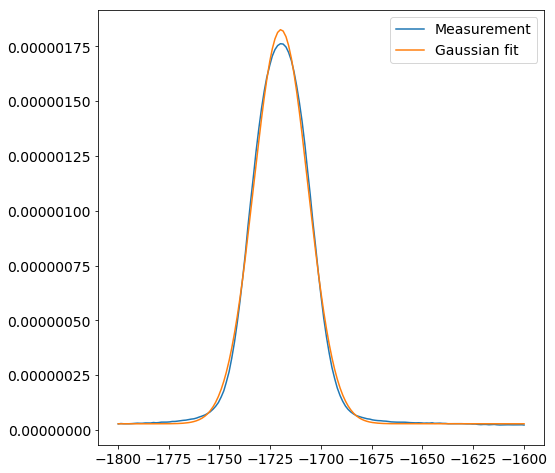

------------ EPU gap = 32, hv = 27.9------------
position= -1721.765436155435


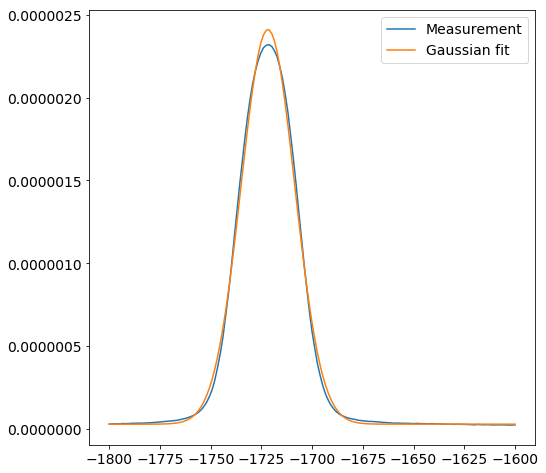

------------ EPU gap = 32, hv = 27.9------------
position= -1722.3339870844447


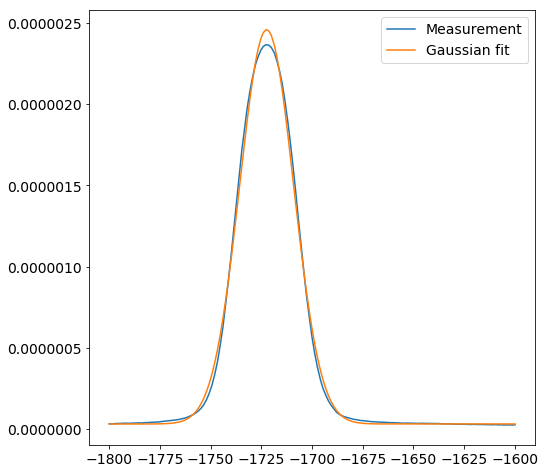

------------ EPU gap = 33, hv = 29.9------------
position= -1724.408358887068


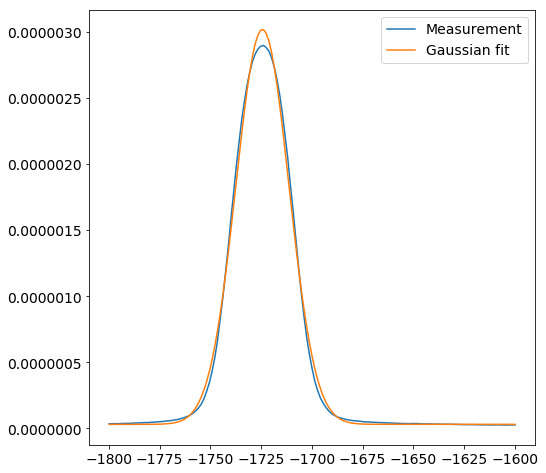

In [11]:
m1_pitch = []
EPU_gap = []
photonEnergy = []


t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1Pitch.h5',5509,5534,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1PitchB.h5',5540,5543,showPlots=True)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1PitchC.h5',5545,5547,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1PitchD.h5',5549,5569,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1PitchE.h5',5571,5586,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])
    
t1,t2,t3 = fitGaussToDiodeGapSet('(18.11.29)_M1PitchF.h5',5588,5641,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

Since this was sometimes done twice for the same gap, go through and take averages so that each gap is single-valued.

In [13]:
EPU_gap_avg = []
M1_pitch_avg = []

minGap = int(round(min(EPU_gap)))
maxGap = int(round(max(EPU_gap)))

for gap in range(minGap,maxGap+1):
    EPU_gap_avg.append(gap)
    total=0
    numDatapoints=0
    
    for datapoint in EPU_gap:
        if abs(datapoint - gap)<0.1:
            total+=m1_pitch[EPU_gap.index(datapoint)]
            numDatapoints+=1
    M1_pitch_avg.append(total/numDatapoints)

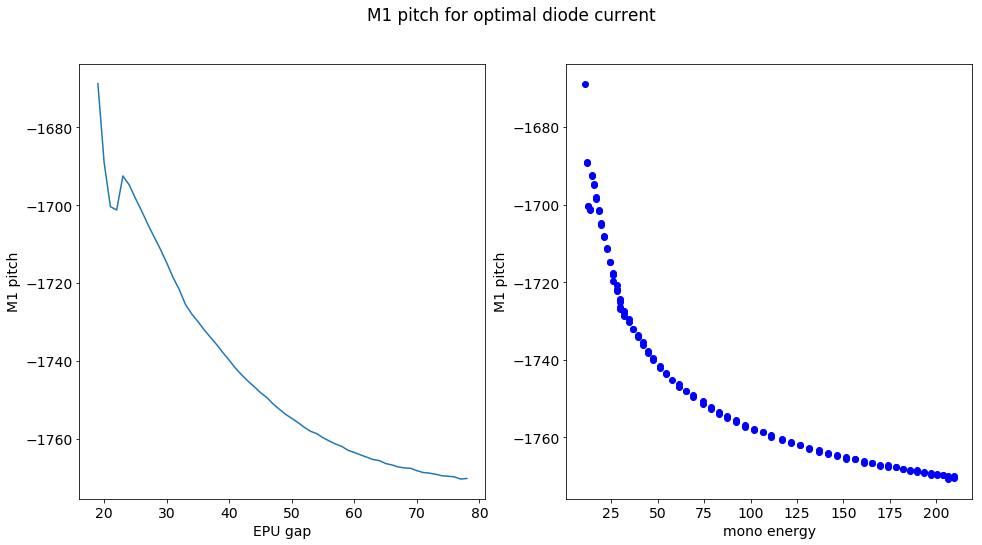

In [15]:
fig=plt.figure(figsize=(16,8))
plt.suptitle('M1 pitch for optimal diode current')
plt.subplot(1,2,1)
plt.xlabel("EPU gap")
plt.ylabel("M1 pitch")
plt.plot(EPU_gap_avg,M1_pitch_avg)
plt.subplot(1,2,2)
plt.xlabel("mono energy")
plt.ylabel("M1 pitch")
plt.plot(photonEnergy,m1_pitch,'bo')
plt.show()

***
## Result set 2: Fix the gap (20mm), step through different hv

------------ EPU gap = 20, hv = 60.0------------
position= -1739.0201621871133


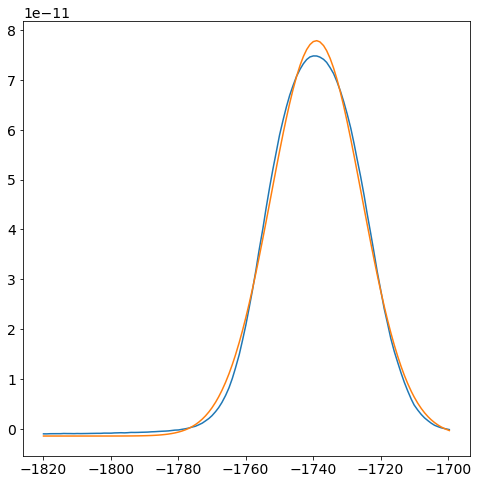

------------ EPU gap = 20, hv = 70.0------------
position= -1741.6876734501689


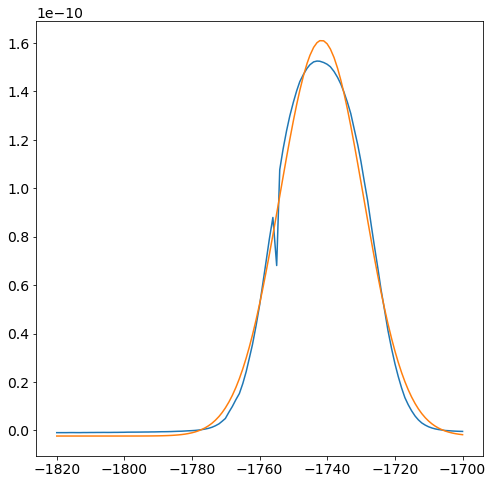

------------ EPU gap = 20, hv = 80.0------------
position= -1746.524643850513


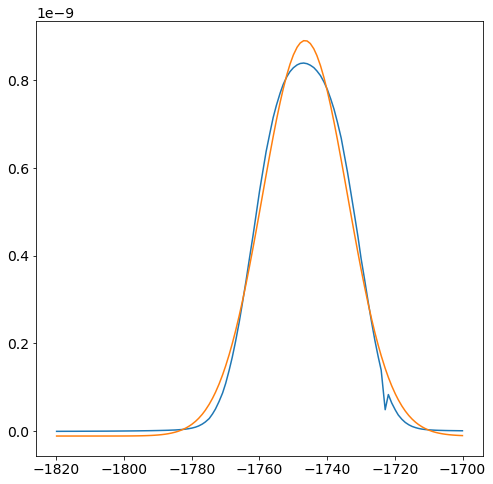

In [16]:
mesh_m1_pitch = []
mesh_EPU_gap = []
mesh_photonEnergy = []

t1,t2,t3 = fitGaussToMeshHVSet('(18.12.01)_M1Pitch_10_20eV_mesh.h5',5662,5678,showPlots=False)
for index,element in enumerate(t1):
    mesh_EPU_gap.append(t1[index])
    mesh_photonEnergy.append(t2[index])
    mesh_m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToMeshHVSet('(18.12.01)_M1Pitch_50_900eV_mesh.h5',5679,5681,showPlots=True)
for index,element in enumerate(t1):
    mesh_EPU_gap.append(t1[index])
    mesh_photonEnergy.append(t2[index])
    mesh_m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToMeshHVSet('(18.12.01)_M1Pitch_50_900eV_mesh.h5',5683,5698,showPlots=False)
for index,element in enumerate(t1):
    mesh_EPU_gap.append(t1[index])
    mesh_photonEnergy.append(t2[index])
    mesh_m1_pitch.append(t3[index])

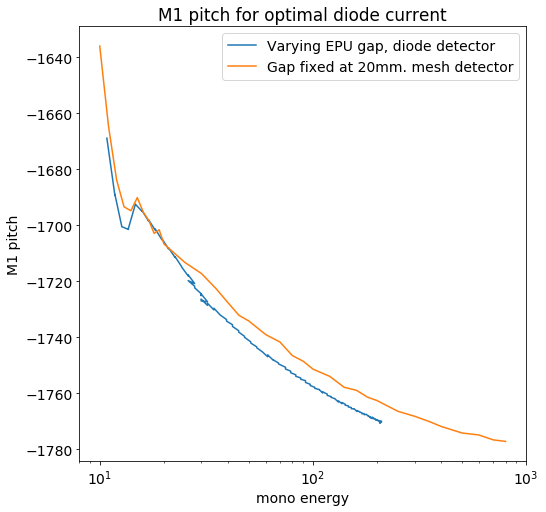

In [18]:
fig=plt.figure(figsize=(8,8))
plt.title('M1 pitch for optimal diode current')

plt.xlabel("mono energy")
plt.ylabel("M1 pitch")
plt.xscale('log')
plt.plot(photonEnergy,m1_pitch,label='Varying EPU gap, diode detector')
plt.plot(mesh_photonEnergy,mesh_m1_pitch,color='tab:orange',label='Gap fixed at 20mm. mesh detector')
plt.legend()
plt.show()

## Save to file:

In [199]:
fp = open("M1_pitch.txt",'w')
fp.write("Photon energy\tM1 pitch\n")
for index,element in enumerate(mesh_photonEnergy):
    fp.write("{0:0.1f}\t{1:0.1f}\n".format(mesh_photonEnergy[index],mesh_m1_pitch[index]))
fp.close()

In [202]:
fp = open("M1_pitch_diode.txt",'w')
fp.write("EPU gap\tPhoton energy\tM1 pitch\n")
for index,element in enumerate(photonEnergy):
    fp.write("{0:0.1f}\t{1:0.1f}\t{2:0.1f}\n".format(EPU_gap[index],photonEnergy[index],m1_pitch[index]))
fp.close()